# XGBoost in Python Tutorial



XGBoost is one of the most popular machine learning frameworks among data scientists.

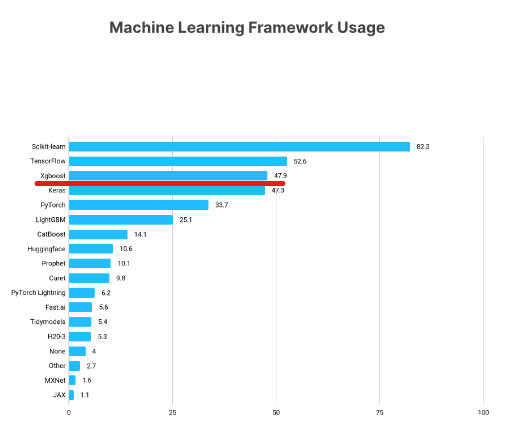

CONTENT:

Throughout this tutorial, we will cover the key aspects of XGBoost, including:

    * Installation

    * XGBoost DMatrix class

    * XGBoost regression

    * Objective and loss functions in XGBoost

    * Building training and evaluation loops

    * Cross-validation in XGBoost

    * Building an XGBoost classifier

    * Changing between Sklearn and native APIs of XGBoost

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



we will just look at the 5-number summary of the numeric and categorical features

In [2]:
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# Build an XGBoost DMatrix

In [4]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

**NOTE:** The dataset has three categorical columns. Normally, you would encode them with ordinal or one-hot encoding, but XGBoost has the ability to internally deal with categoricals.

*       The way to enable this feature is to cast the categorical columns into Pandas category data type

_________________________________________________________________________________________________________________________________

*     This code snippet is used to extract text features from a dataset and convert them to Pandas category data type.

In [5]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')


In [6]:
#we have three category features
X.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

XGBoost comes with its own class for storing datasets called DMatrix. It is a highly optimized class for memory and speed. 

That's why converting datasets into this format is a requirement for the native XGBoost API

In [8]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [9]:
mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)

NameError: name 'actual' is not defined

# Training

This code defines hyperparameters for a regression model using XGBoost library in Python.
*     First, a dictionary params is defined with two key-value pairs: "objective": "reg:squarederror" specifies that the objective of the model is to minimize the mean squared error, and "tree_method": "gpu_hist" specifies that the model should use GPU acceleration for histogram-based tree building.
*     Next, a variable n is defined with a value of 100, which specifies the number of boosting rounds (iterations) for the model.
*     Finally, the xgb.train() function is called with the params dictionary, a training dataset dtrain_reg, and the number of boosting rounds n.
*     This function trains the XGBoost regression model with the specified hyperparameters and returns the trained model.

The ideal number of rounds is found through hyperparameter tuning. For now, we will just set it to 100:

In [ ]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

# Evaluation

During the boosting rounds, the model object has learned all the patterns of the training set it possibly can.

Now, we must measure its performance by testing it on unseen data. That's where our dtest_reg DMatrix comes into play:

In [ ]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)

The process is called model evaluation. 
Once you generate predictions with predict, you pass them inside mean_squared_error function of Sklearn to compare against y_test:

In [ ]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

We’ve got a base score ~541, which was the performance of a base model with default parameters. 

There are two ways we can improve it— by performing cross-validation and hyperparameter tuning. 

But before that, let’s see a quicker way of evaluating XGBoost models.

# Using Validation Sets During Training

we will use evaluation arrays that allow us to see model performance as it gets improved incrementally across boosting rounds.

In [ ]:
params = {"objective": "reg:squarederror"}
n = 100

#The first element is the array for the model to evaluate, and the second is the array’s name.

In [ ]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
)

# What’s best is that we can see the model’s performance on both our training and validation sets. 
#Usually, the training loss will be lower than validation since the model has already seen the former.

# XGBoost Early Stopping

Early stopping forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

In [ ]:
n = 10000


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)


# XGBoost Cross-Validation

But only a single test set would not be enough to measure how a model would perform in production accurately. For example, if we perform hyperparameter tuning using only a single training and a single test set, knowledge about the test set would still “leak out.”

While the test set waits in the corner, we split the training into 3, 5, 7, or k splits or folds. Then, we train the model k times. Each time, we use k-1 parts for training and the final kth part for validation. This process is called k-fold cross-validation:

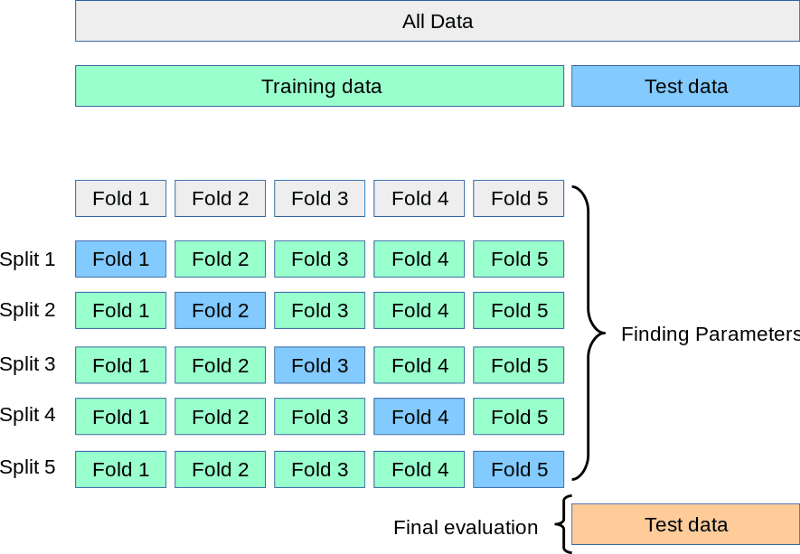

Above is a visual depiction of a 5-fold cross-validation. After all folds are done, we can take the mean of the scores as the final, most realistic performance of the model.

--> cross-validation is used to see the true performance of the model.

In [ ]:
params = {"objective": "reg:squarederror"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

In [ ]:
results.head()

In [ ]:
best_rmse = results['test-rmse-mean'].min()
best_rmse